<a href="https://colab.research.google.com/github/sivarohith99/Grant_title_genration/blob/main/BART_base_grant_title_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets rouge-score bert-score torch nltk
!pip install git+https://github.com/neulab/BARTScore.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=4f50def8ad5474e65c6534eb77af879905fed708ad69838de7845f3b7073141f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's d

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = "title_abstract.xlsx"
data = pd.read_excel(file_path)

# Check dataset structure
print(data.head())  # Ensure columns like "abstract" and "title" exist

# Split the dataset
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% training
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 15% validation, 15% testing

# Save splits into DataFrames
train_data.to_csv("train.csv", index=False)
val_data.to_csv("val.csv", index=False)
test_data.to_csv("test.csv", index=False)


                                doi  \
0     10.1090/S0002-9939-06-08360-2   
1                 10.1021/JO200213X   
2  10.1111/J.1468-0262.2008.00849.X   
3         10.1017/S0074180900195506   
4          10.1109/TSP.2015.2449255   

                                               title  \
0  A note on uniformization of riemann surfaces b...   
1  With a little help from my friends: forty year...   
2                    Political Economy of Mechanisms   
3  WIYN Open Cluster Study: Tidal Interactions in...   
4  A Saddle Point Algorithm for Networked Online ...   

                                            abstract  
0  We clarify that the Ricci flow can be used to ...  
1  Over the past 40 years, much of the author's r...  
2  We study the optimal Mirrlees taxation problem...  
3  We present an ongoing study on tidal interacti...  
4  An algorithm to learn optimal actions in conve...  


In [3]:
from datasets import Dataset
from transformers import BartTokenizer

# Load datasets
train_dataset = Dataset.from_pandas(pd.read_csv("train.csv"))
val_dataset = Dataset.from_pandas(pd.read_csv("val.csv"))
test_dataset = Dataset.from_pandas(pd.read_csv("test.csv"))

# Initialize tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Preprocessing function
def preprocess_data(examples):
    inputs = tokenizer(
        examples['abstract'], max_length=512, truncation=True, padding="max_length", return_tensors="pt"
    )
    targets = tokenizer(
        examples['title'], max_length=128, truncation=True, padding="max_length", return_tensors="pt"
    )
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': targets['input_ids']
    }

# Apply preprocessing
tokenized_train = train_dataset.map(preprocess_data, batched=True, remove_columns=['abstract', 'title'])
tokenized_val = val_dataset.map(preprocess_data, batched=True, remove_columns=['abstract', 'title'])
tokenized_test = test_dataset.map(preprocess_data, batched=True, remove_columns=['abstract', 'title'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/746 [00:00<?, ? examples/s]

Map:   0%|          | 0/747 [00:00<?, ? examples/s]

In [4]:
from transformers import BartForConditionalGeneration, Trainer, TrainingArguments

# Load model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save the model at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs',
    load_best_model_at_end=True
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-eadfc2d5c82e>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.429992
2,1.032200,0.417942
3,0.379400,0.419296


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1308, training_loss=0.618742146623244, metrics={'train_runtime': 1013.1814, 'train_samples_per_second': 10.307, 'train_steps_per_second': 1.291, 'total_flos': 3183738916700160.0, 'train_loss': 0.618742146623244, 'epoch': 3.0})

In [5]:
trainer.save_model('./fine_tuned_model')

In [7]:
!wget https://raw.githubusercontent.com/neulab/BARTScore/main/bart_score.py
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from bart_score import BARTScorer  # Now, it should import correctly


--2024-11-30 18:15:21--  https://raw.githubusercontent.com/neulab/BARTScore/main/bart_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4221 (4.1K) [text/plain]
Saving to: ‘bart_score.py’

bart_score.py       100%[===================>]   4.12K  --.-KB/s    in 0s      

2024-11-30 18:15:22 (68.1 MB/s) - ‘bart_score.py’ saved [4221/4221]



In [8]:
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from bart_score import BARTScorer  # Import BARTScore
import torch
import pandas as pd

# Load the fine-tuned model and tokenizer
model = BartForConditionalGeneration.from_pretrained('./fine_tuned_model').to('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Initialize BARTScorer
bart_scorer = BARTScorer(device='cuda' if torch.cuda.is_available() else 'cpu', checkpoint='facebook/bart-large-cnn')

# Read the test dataset
test_data = pd.read_csv("test.csv")

# Define batch size for evaluation
batch_size = 16

# Function to evaluate in batches
def evaluate_model(model, tokenizer, test_data, batch_size=16):
    results = []
    # Create batches
    for start in range(0, len(test_data), batch_size):
        batch = test_data.iloc[start:start + batch_size]

        # Tokenize the abstracts in the batch
        inputs = tokenizer(batch['abstract'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512).to(model.device)

        # Generate text for the batch
        generated_ids = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
        generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Calculate ROUGE, BERTScore, and BARTScore for the batch
        for idx, example in batch.iterrows():
            reference_text = example['title']
            generated_text = generated_texts[idx - start]

            # ROUGE Scores
            rouge_scores = rouge_scorer.score(reference_text, generated_text)

            # BERTScore
            bert_scores = bert_score([generated_text], [reference_text], lang='en')

            # BARTScore
            bartscore = bart_scorer.score([generated_text], [reference_text])

            results.append({
                "reference": reference_text,
                "generated": generated_text,
                "rouge": {
                    "rouge1": rouge_scores['rouge1'].fmeasure,
                    "rouge2": rouge_scores['rouge2'].fmeasure,
                    "rougeL": rouge_scores['rougeL'].fmeasure
                },
                "bert": bert_scores[2][0].item(),
                "bart": bartscore[0]  # Assuming BARTScorer returns a list
            })

    return results


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [9]:
# Evaluate the model on test data
results = evaluate_model(model, tokenizer, test_data, batch_size=batch_size)

# Convert results to a DataFrame for better analysis and saving
results_df = pd.DataFrame([
    {
        "Reference": res["reference"],
        "Generated": res["generated"],
        "ROUGE-1": res["rouge"]["rouge1"],
        "ROUGE-2": res["rouge"]["rouge2"],
        "ROUGE-L": res["rouge"]["rougeL"],
        "BERTScore": res["bert"],
        "BARTScore": res["bart"]
    }
    for res in results
])

# Save results to a CSV file
results_df.to_csv("evaluation_results.csv", index=False)

print("Evaluation completed. Results saved to 'evaluation_results.csv'.")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Evaluation completed. Results saved to 'evaluation_results.csv'.


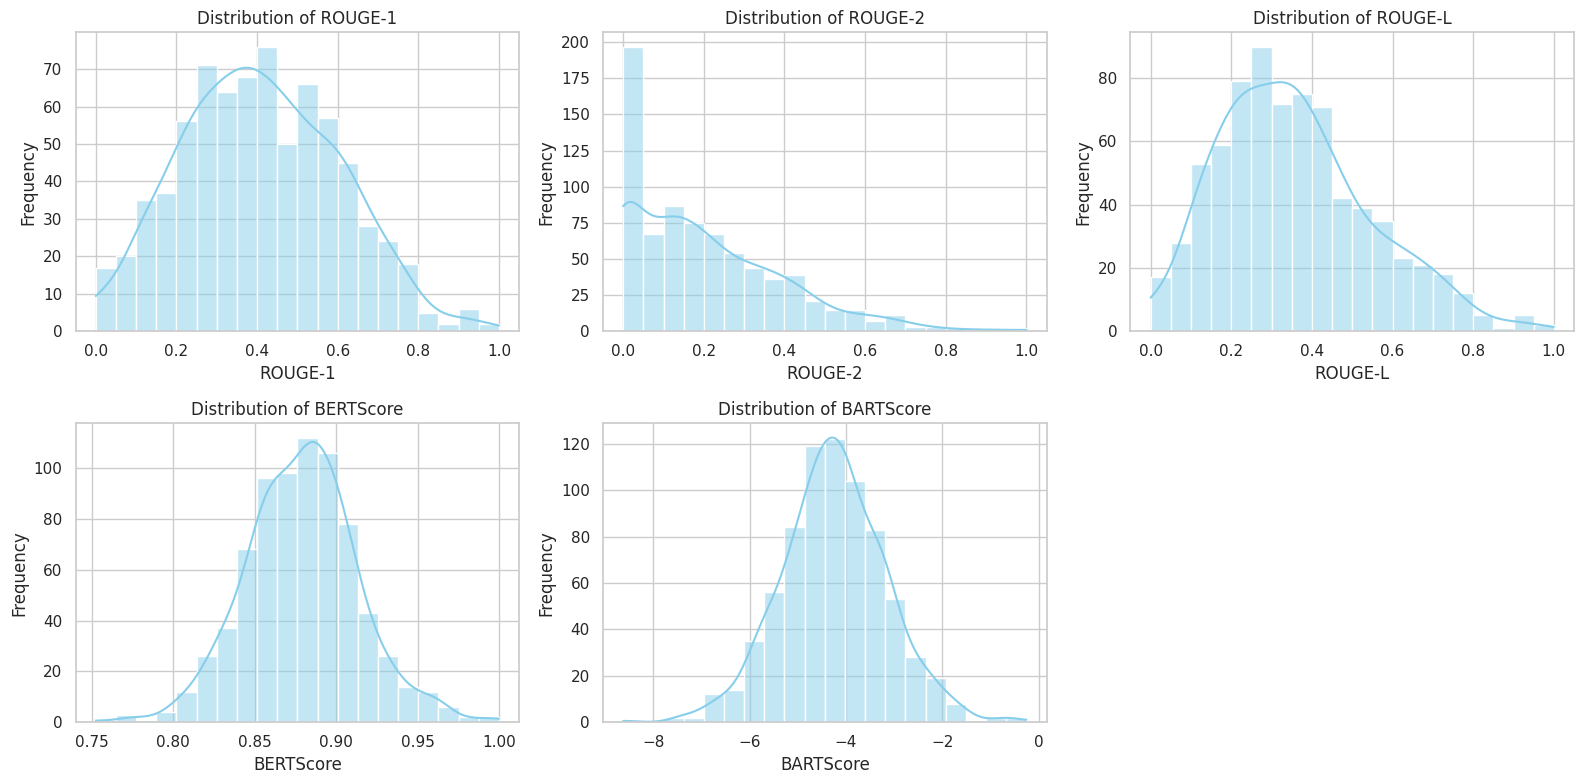

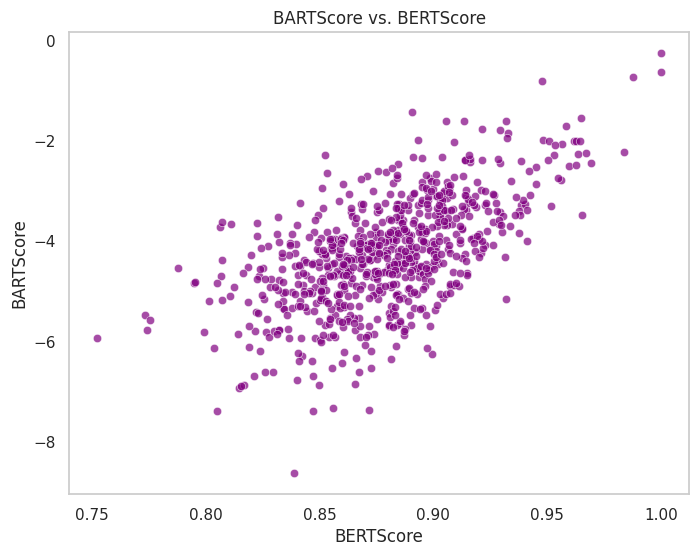

<ipython-input-10-273a6e83cb94>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Average Score", data=avg_df, palette="coolwarm")


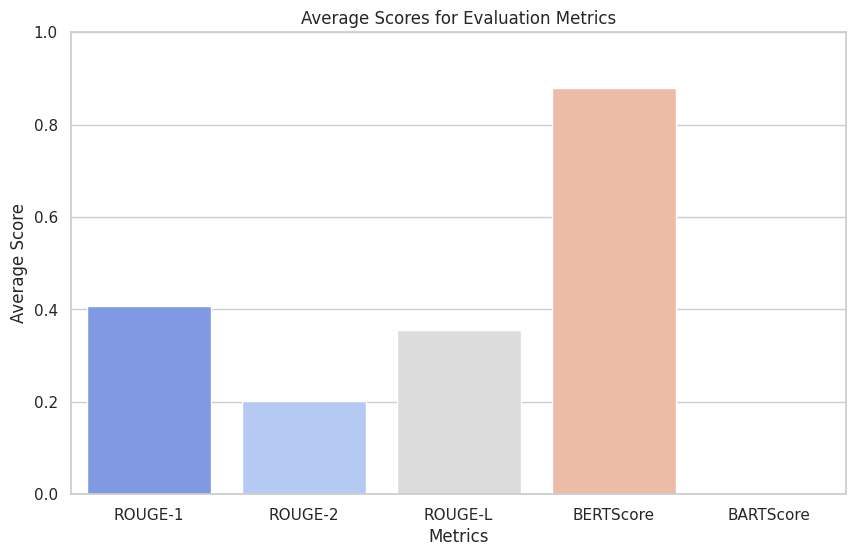

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load evaluation results
results_df = pd.read_csv("evaluation_results.csv")

# Set up the visualization style
sns.set_theme(style="whitegrid")

# Plot distributions of ROUGE, BERTScore, and BARTScore
def plot_score_distributions(df):
    plt.figure(figsize=(16, 8))

    metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore", "BARTScore"]
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[metric], kde=True, bins=20, color='skyblue')
        plt.title(f"Distribution of {metric}")
        plt.xlabel(metric)
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Scatter plot: BARTScore vs. BERTScore
def scatter_plot_bart_vs_bert(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="BERTScore", y="BARTScore", data=df, color="purple", alpha=0.7)
    plt.title("BARTScore vs. BERTScore")
    plt.xlabel("BERTScore")
    plt.ylabel("BARTScore")
    plt.grid()
    plt.show()

# Bar plot: Average scores for ROUGE and BERT/BART scores
def plot_average_scores(df):
    avg_scores = {
        "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore", "BARTScore"],
        "Average Score": [
            df["ROUGE-1"].mean(),
            df["ROUGE-2"].mean(),
            df["ROUGE-L"].mean(),
            df["BERTScore"].mean(),
            df["BARTScore"].mean(),
        ],
    }
    avg_df = pd.DataFrame(avg_scores)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Metric", y="Average Score", data=avg_df, palette="coolwarm")
    plt.title("Average Scores for Evaluation Metrics")
    plt.xlabel("Metrics")
    plt.ylabel("Average Score")
    plt.ylim(0, 1)
    plt.show()

# Call the visualization functions
plot_score_distributions(results_df)
scatter_plot_bart_vs_bert(results_df)
plot_average_scores(results_df)


In [12]:
import pandas as pd

# Load the evaluation results
results_df = pd.read_csv("evaluation_results.csv")

# Calculate the average for each metric
average_metrics = {
    "ROUGE-1": results_df["ROUGE-1"].mean(),
    "ROUGE-2": results_df["ROUGE-2"].mean(),
    "ROUGE-L": results_df["ROUGE-L"].mean(),
    "BERTScore": results_df["BERTScore"].mean(),
    "BARTScore": results_df["BARTScore"].mean()
}

# Print the averages
print("Average Metrics:")
for metric, value in average_metrics.items():
    print(f"{metric}: {value:.4f}")


Average Metrics:
ROUGE-1: 0.4077
ROUGE-2: 0.2025
ROUGE-L: 0.3555
BERTScore: 0.8791
BARTScore: -4.2486
